In [4]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [6]:
# running experiments
from experiments.run_experiment import (
    TrainingConfig,
    EvaluateConfig,
)
from experiments.run_sweep import run_sweep, plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_utils import asymmetric_alphas

# environments
from environments.cliffwalking import CliffWalkingConfig, get_cliffwalking_env
from environments.taxi_v3 import TaxiV3Config, get_taxi_v3_env

# SARSA Variant agent
from agents.sarsa_td0_positivity_bias import (
    SarsaTD0VariantAgent,
    SarsaTD0VariantConfig,
)

# metrics for training
from metrics.learning_mertrics import total_reward_per_episode, episode_won_cliffwalking
from metrics.frustration_metrics import (
    total_td_error_per_episode,
    frustration_rate_per_episode,
    tail_frustration_per_episode,
    cvar_tail_frustration_per_episode,
)

# external libraries
import numpy as np

## Environments

In [ ]:
env_config = CliffWalkingConfig()

## Agents

In [4]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0VariantAgent

sarsa_td0_config = SarsaTD0VariantConfig(
    alpha_positive=0.2,
    alpha_negative=0.2,
    gamma=0.99,
    epsilon=0.3,
    reward_metrics={
        "total_reward_per_episode": total_reward_per_episode,
        "episode_won": episode_won_cliffwalking,
    },
    td_error_metrics={
        "total_td_error_per_episode": total_td_error_per_episode,
        "frustration_rate_per_episode": frustration_rate_per_episode,
        "tail_frustration_per_episode": lambda td: tail_frustration_per_episode(
            td, percentile=0.90
        ),
        "cvar_tail_frustration_per_episode": lambda td: cvar_tail_frustration_per_episode(
            td, percentile=0.90
        ),
    },
)

## Sweep configuration

In [5]:
base_train = TrainingConfig(
    name="sarsa_frozenlake",
    num_train_episodes=30000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="sarsa_frozenlake",
    num_eval_episodes=2000,
    env_kwargs={"config": env_config},
)

In [6]:
# different q_tables
env = get_cliffwalking_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

In [7]:
a_0 = 0.2
ratios = [0.25, 0.5, 1.0, 2.0, 4.0]

In [ ]:
sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(a_0, r),
            "seed": 1,
            "initial_q_table": q0,
            "initial_q_table_label": f"zeros",
        }
        for r in ratios
    ],
}

## Results

In [9]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_cliffwalking_env,
    agent_factory=agent_factory,
)


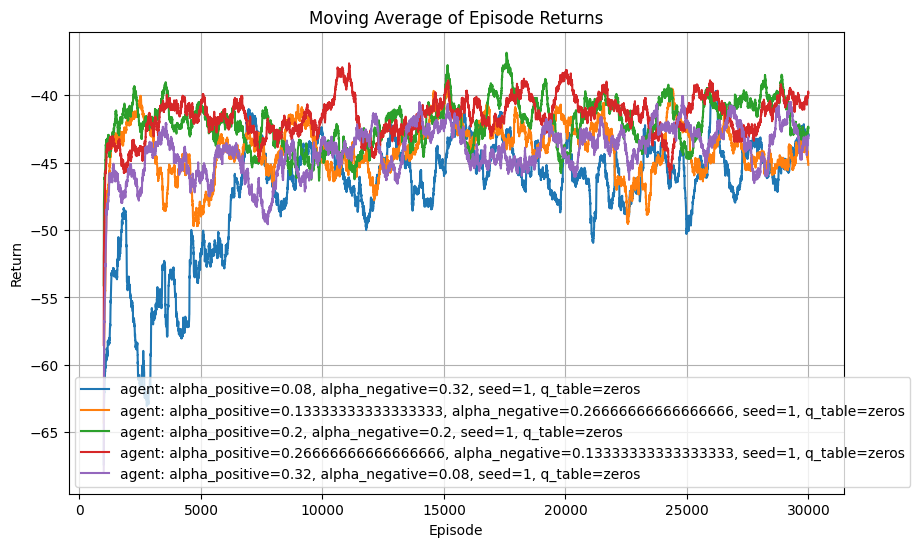

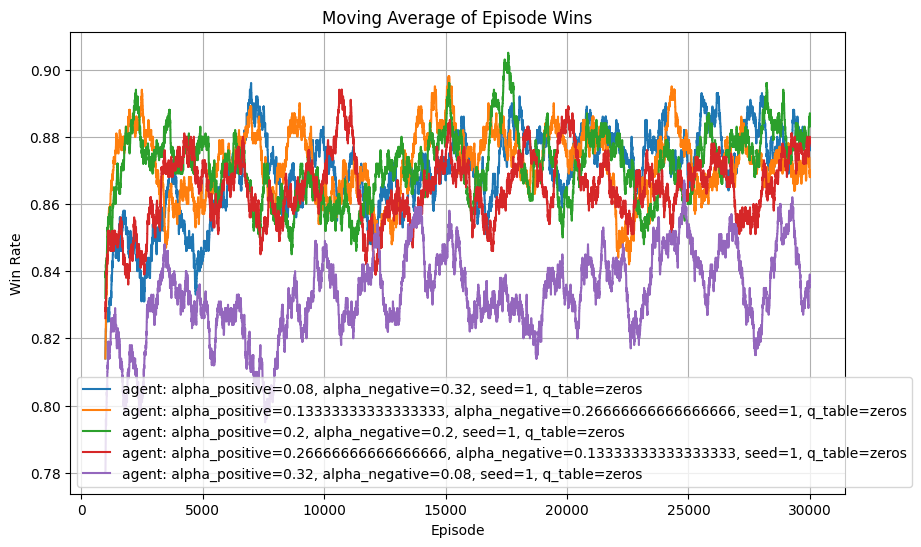

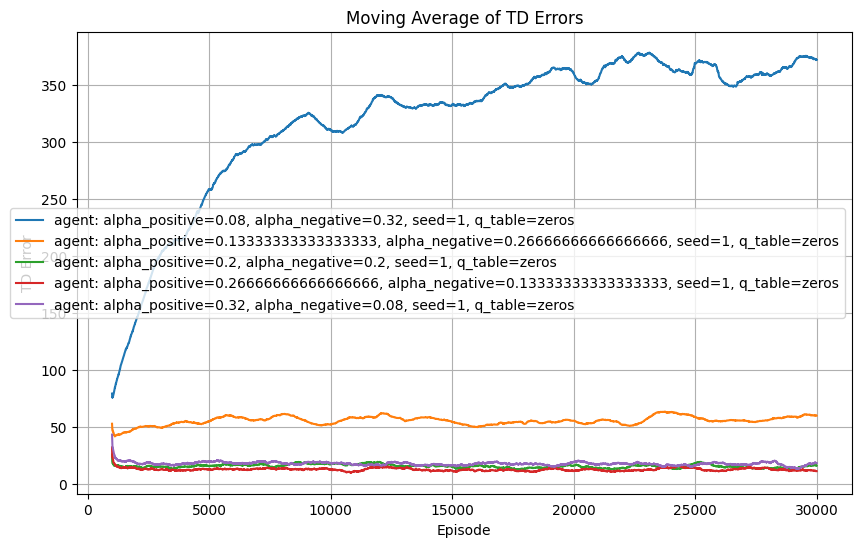

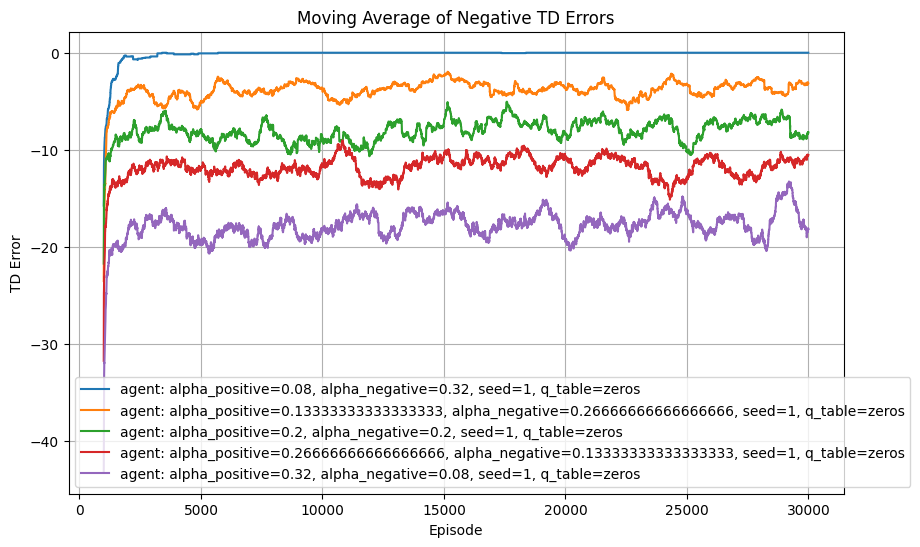

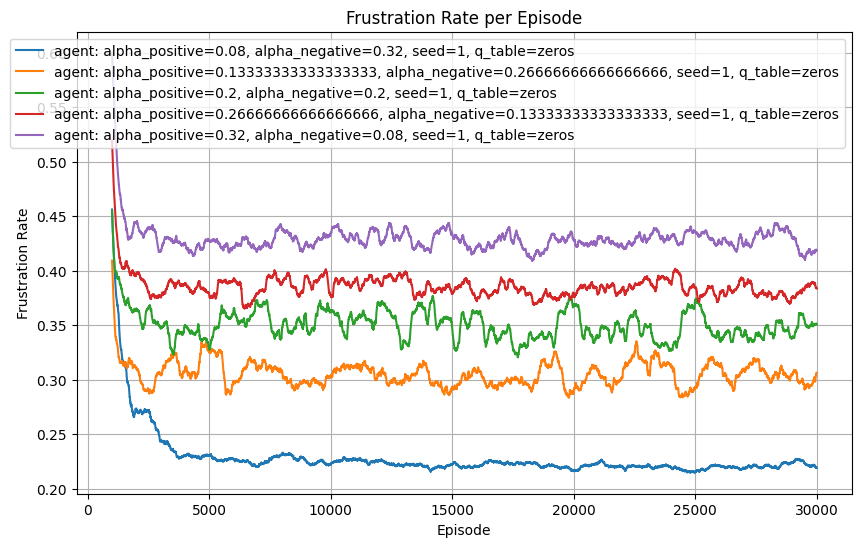

In [10]:
plot_sweep_training(results, window_size=1000)

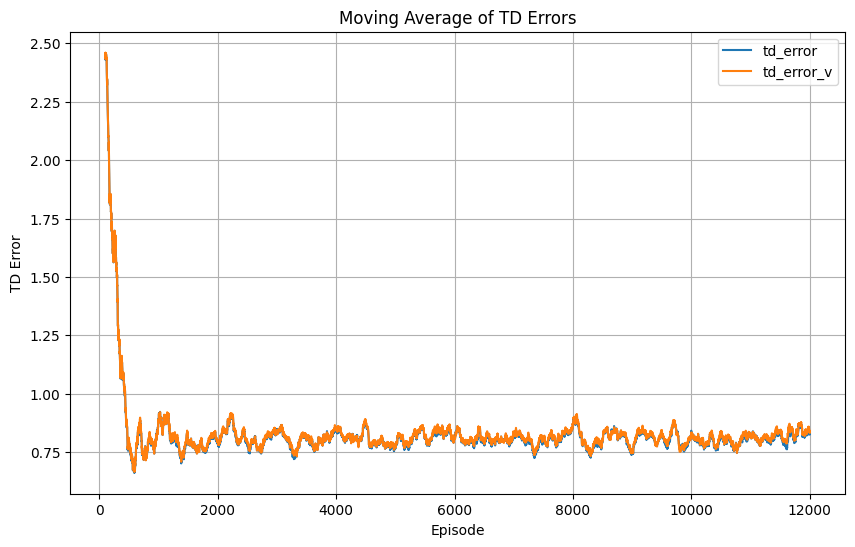

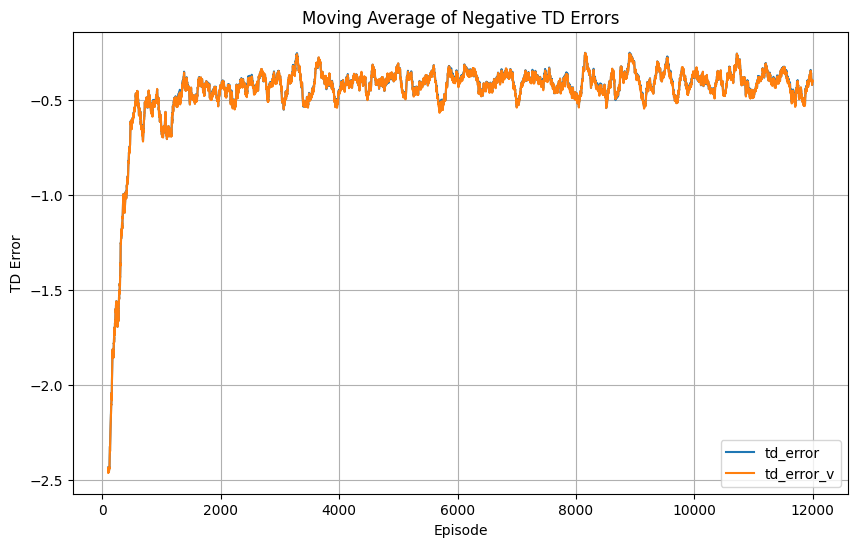

In [22]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


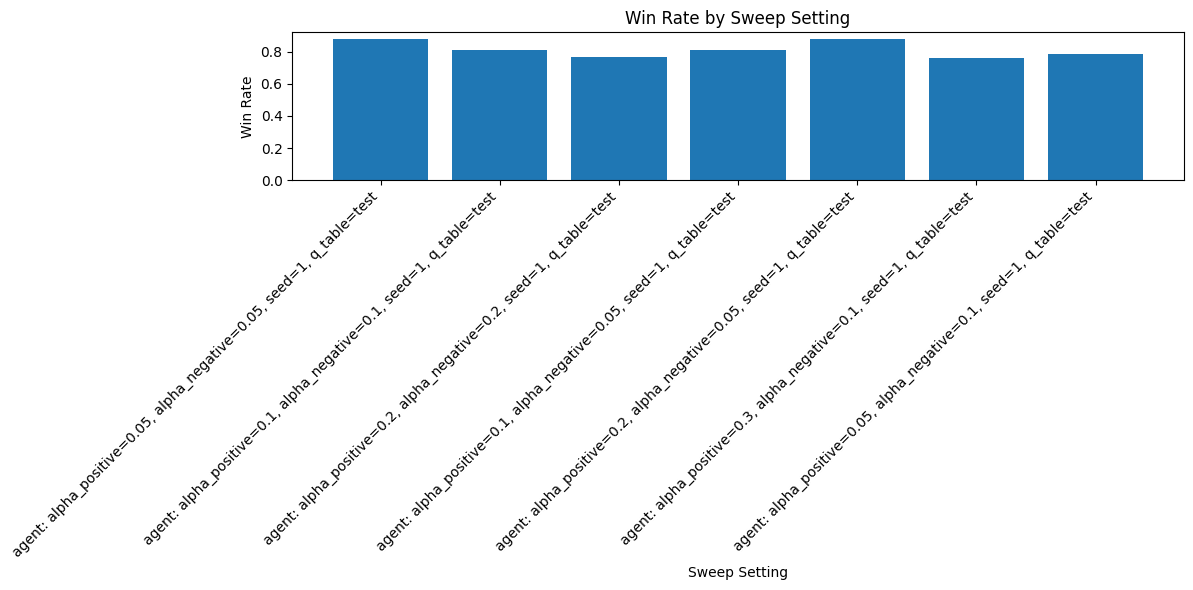

In [23]:
plot_sweep_evaluation(results)